DB: Analytical solution test 1
=====

Comparison of a solutions obtained via ``underworld2`` and analytic solutions provided by Dohrmann and Bochev (2004) (equations 48-50).

**References**

1. C. R. Dohrmann and P. B. Bochev, A stabilized finite element method for the Stokes problem based on polynomial pressure projections, IJNMF, 46(2), 183-201, 2004
http://onlinelibrary.wiley.com/doi/10.1002/fld.752/full

The SolDb2d analytic solution is run over a range of resolutions with the error (in velocity and pressure) measured at each conffiguration. The error convergence is analysed against the expected element type order.

In [1]:
import underworld as uw
import glucifer
from underworld import function as fn
import numpy as np

In [2]:
# SolDB object contains the analytic solution and parameter (ie, viscosity, density) profiles
sol = fn.analytic.SolDB2d()

In [3]:
elTypeToUse = "Q2/dQ1"

# expected order of convergence results for Q2/dQ1
# velocity for Q2 -> 3rd order convergence
# pressure is dQ1 -> 2nd order convergence 
expected_order = np.array([2.9,1.9])

# Resolutions to test against
res = [(16,16),(32,32),(64,64)]

In [4]:
def analyticMeasure( numeric, analytic, mesh ):
    '''
    Measure the integrated error between 2 MeshVariables (or uw.Functions) over the mesh
    
    Returns
    -------
    rel, err: ndarray, ndarray
        Array representing the relative and absolute errors between the MeshVariables
        The lengths are the number of components of the field
    '''
    
    # functional description of L2 norm sums; error and magnitude
    fn_err = fn.math.dot(numeric - analytic, numeric-analytic)
    fn_norm = fn.math.pow(analytic, 2.)
    
    # perform L2 norm evaluation        
    err = fn.math.sqrt(uw.utils.Integral( fn_err, mesh ).evaluate()).evaluate()[0]
    norm = fn.math.sqrt(uw.utils.Integral( fn_norm, mesh ).evaluate()).evaluate()[0]
    
    # calculate relative error measures
    rel = err / norm
    
    return rel, err

In [5]:
def analyticSol_SingleResolutionTest( sol, elType, resolution ):
    """
    Test a FEM model against an analytic solution
    
    Parameters
    ----------
    sol : fn.analyic._SolBase
        The python wrapped analyic solution.
        
    elType: string
        The element type desired, as these equation solve stokes this must
        describe a mesh/subMesh pair, eg 'Q1/dQ0'.
    
    resolution: integer tuple
        The resolution of the mesh.
    """

    # 'global' python vars are visible outside this function's scope
    global mesh
    global velocityField
    global pressureField
    global solver
    
    mesh = uw.mesh.FeMesh_Cartesian(elType, resolution, (0.,0.), (1.,1.))

    velocityField = uw.mesh.MeshVariable(mesh,2)
    velocityField.data[:] = (0.,0.)
    
    # use the analytic solution to define the dirichlet bcs
    vel=sol.fn_velocity
    velocityField.data[:] = vel.evaluate(mesh.data)
    
    pressureField = uw.mesh.MeshVariable(mesh.subMesh,1)
    pressureField.data[:] = 0.

    # currently not checking strain rate
    # strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
    
    # freeslip
    IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
    JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
    vBCs = uw.conditions.DirichletCondition(velocityField, (IWalls+JWalls, IWalls+JWalls))

    stokesSystem = uw.systems.Stokes(velocityField,pressureField,
                                     sol.fn_viscosity,sol.fn_bodyforce,
                                     conditions=[vBCs,])
    # Run the BSSCR Solver
    solver=uw.systems.Solver(stokesSystem)
    # tighter tolerances 
    solver.options.scr.ksp_rtol=1e-8  # tolerance for the scr solve, default is 1e-5.
    solver.options.A11.ksp_rtol=1e-8  # tolerance for the inv K approximation
    solver.solve()
    
    v_err, abs_v_err = analyticMeasure( velocityField, sol.fn_velocity, mesh )
    p_err, abs_p_err = analyticMeasure( pressureField, sol.fn_pressure, mesh )
    
    return v_err, p_err

In [6]:
# store the error measures
vel = []
p  = []

ssize = len(res) # the number of samples

for i in range(ssize):
    test_err = analyticSol_SingleResolutionTest( sol, elTypeToUse, res[i])
    
    vel.append(test_err[0][0]) # get vel error
    p.append(test_err[1][0])  # get pressure

In [7]:
# take the log of error measures
yvel = np.log(vel)
yp  = np.log(p)

In [8]:
# assume square resolutions - only take x-res
res_x = np.asarray( res )[:,0]
# h = log(1/res_x)
h = np.log(np.reciprocal(res_x.astype(float)))
# prepare a matrix
A = np.vstack([h, np.ones(len(h))]).T

In [9]:
velm, c = np.linalg.lstsq(A, yvel)[0]
pm, c = np.linalg.lstsq(A, yp)[0]

In [10]:
test = np.array([velm, pm])

In [11]:
if uw.rank()==0:
    np.all(np.less(expected_order, test))

    if not np.all(np.less(expected_order, test)):
        raise RuntimeError("The numerical order of convergence is outside the error threshold."+
        "The Relative error found were ", test," the threshold is ", expected_order )  

### Order of convergence with tolerance with Q2/dQ1
 
 |tol scr | tol A11 | O(v_err)   | O(p_err)   |
 |--------|---------|------------|------------|
 | 1e-5 |1e-6 | 2.8519131  | 0.75335309 |
 | 1e-6 |1e-6 | 2.85560521 | 1.14948763 |
 | 1e-6 |1e-7 | 2.855289   | 1.14857845 |
 | 1e-7 |1e-7 | 2.85549347 | 1.7223448  |
 | 1e-7 |1e-8 | 2.99996629 | 1.80303023 |
 | 1e-8 |1e-8 | 2.99997216 | 1.99653218 |
 | **1e-8 | 1e-6 | 2.85617013 | 1.96276391** |
 
* With Q1/dQ0 element types the Schur complement loop, 'scr' always failed to converge after 10000 iterations.

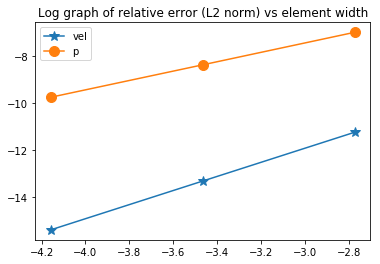

In [12]:
if uw.rank()==0:
    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.plot(h, yvel, '*-', label='vel', markersize=10)
    pyplot.plot(h, yp, 'o-', label='p', markersize=10)
    pyplot.legend(loc=2)
    pyplot.title("Log graph of relative error (L2 norm) vs element width")
    pyplot.savefig("solDB2d") if uw.nProcs() > 1 else pyplot.show()

In [13]:
figViscosity = glucifer.Figure()
figForce = glucifer.Figure(**figViscosity)


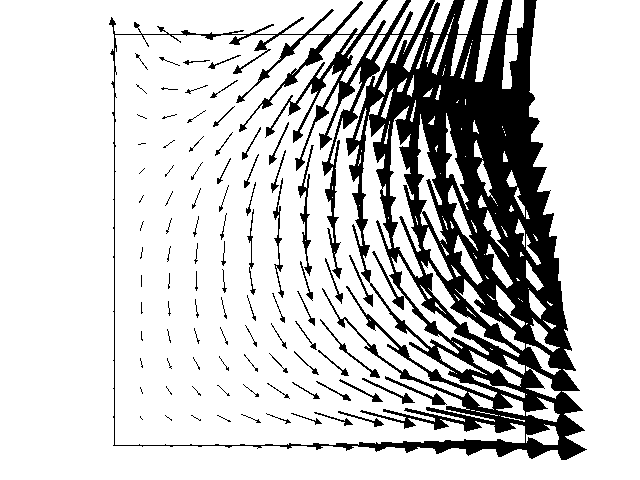


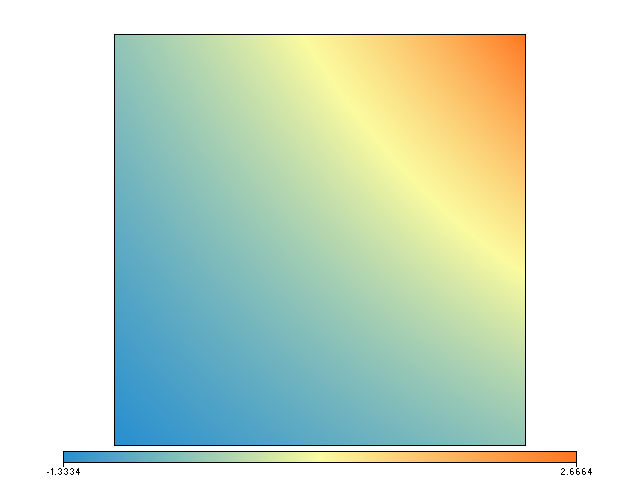

In [14]:
# figViscosity.append( glucifer.objects.Surface(mesh, fn=sol.fn_velocity[1], onMesh=True) )
figViscosity.append( glucifer.objects.VectorArrows(mesh, fn=sol.fn_velocity, scaling=0.1) )
figViscosity.show()
figForce.append( glucifer.objects.Surface(mesh, fn=pressureField,onMesh=True) )
figForce.show()

## Below are some plots from M. Velic's original model

Commented out currently

In [15]:
# # and difference
# diff = sol.fn_velocity - velocityField
# velDiff = glucifer.Figure()
# velDiff.append(glucifer.objects.Surface(velocityField.mesh, fn.math.dot(diff,diff) ))
# velDiff.show()

In [16]:
# import numpy as np
# N=201
# a=np.ndarray(shape=(N,2))
# a[:,1]=0.75*np.ones(N)
# a[:,0]=np.linspace(0,1,N)
# import matplotlib.pyplot as mplt
# import matplotlib.pylab as pylab
# vy=sol.fn_velocity[1].evaluate(a)[:,0]
# ax=a[:,0]
# vf=velocityField[1].evaluate(a)[:,0]
# mplt.plot(ax,vf,label='Numerical Velocity')
# #mplt.plot(ax,vy,label='Exact Velocity')
# mplt.plot(ax,1e6*(vy-vf),label='Error (x 1e+6)')
# mplt.legend(loc=3)

In [17]:
# N=801
# a=np.ndarray(shape=(N,2))
# a[:,0]=0.85*np.ones(N)
# a[:,1]=np.linspace(0,1,N)
# ax=a[:,1]
# pex=sol.fn_pressure.evaluate(a)[:,0]
# y=a[:,1]
# pfd=pressureField.evaluate(a)[:,0]
# mplt.plot(y,pfd,label='Numerical')
# mplt.plot(y,pex,label='Exact')
# mplt.plot(y,100*(pfd-pex),label='Error (x 100)')
# mplt.legend(loc=2)